In [145]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import itertools
import time
import random

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

In [146]:
#downloading the pricing dataset
import boto3
s3 = boto3.client('s3')
s3.download_file('aws-carro-hackathon', 'pricing/pricing.tar', 'pricing.tar')

In [147]:
#opening up the .tar file 
import tarfile

file = tarfile.open('pricing.tar')
file.extractall('./')
file.close()

In [148]:
#read in datasets
coe_df = pd.read_csv('./pricing/ps1/coeBiddingResults.csv')
price_df = pd.read_csv('./pricing/ps1/retailCarSoldPrices.csv')

In [149]:
#COE dataset
coe_df.head()
#read in datasets
coe_df.dropna(axis=1, how='all', inplace=True)
coe_df["Category"].replace({'Cat A (Cars up to 1600cc and 97kW)': "A", "Cat B (Cars above 1600cc or 97kW)": "B"}, inplace=True)
coe_df["Demand/Supply"] = (coe_df["Total Bids Received"] / coe_df["Quota"])
coe_df["Announcement Date"] = pd.to_datetime(coe_df["Announcement Date"], format='%Y-%m-%d')
coe_df.head()

,Bidding Exercise,Announcement Date,Year,Category,Quota,Total Bids Received,Number of Successful Bids,Demand/Supply
0,October 2007 Second Open Bidding Exercise,2007-10-15,2007,A,2158,2472,2158,1.145505
1,November 2007 First Open Bidding Exercise,2007-11-01,2007,A,2164,3040,2149,1.404806
2,November 2007 Second Open Bidding Exercise,2007-11-15,2007,A,2158,2450,2154,1.135310
3,December 2007 First Open Bidding Exercise,2007-12-01,2007,A,2174,2373,2171,1.091536
4,December 2007 Second Open Bidding Exercise,2007-12-15,2007,A,2162,2588,2089,1.197040


Text(0.5, 1.0, 'Demand & Supply Ratio over Time')

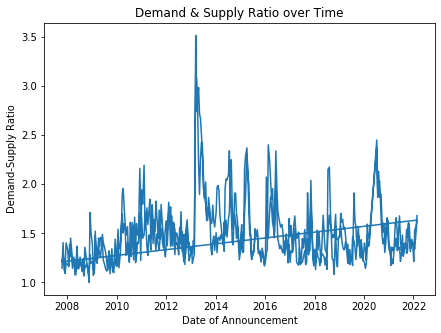

In [150]:
#plotting the COE dataset: Demand/Supply ratio over time 
plt.plot(coe_df["Announcement Date"], coe_df["Demand/Supply"])

plt.ticklabel_format(axis = "y", style = "plain")
plt.xlabel("Date of Announcement")
plt.ylabel("Demand-Supply Ratio")
plt.title("Demand & Supply Ratio over Time")

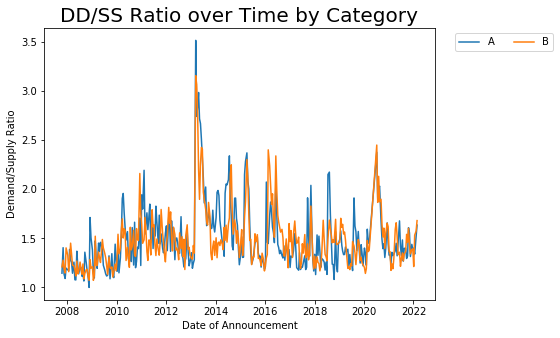

In [151]:
#differences between Cat A and Cat B in COE
for category in ["A", "B"]:
    temp_df = coe_df[coe_df.Category == category]
    plt.plot(temp_df["Announcement Date"], temp_df["Demand/Supply"], label=category)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.ticklabel_format(axis="y", style='plain')
plt.xlabel("Date of Announcement")
plt.ylabel("Demand/Supply Ratio")
plt.title('DD/SS Ratio over Time by Category', fontsize = 20)
plt.show()    

Notes: From the demand-supply ratio (?) of COE over time, there was a spike in demand over the number of COEs supplied between 2013 and 2014. https://blog.moneysmart.sg/transportation/the-singapore-coe-from-cheaper-than-chicken-rice-to-more-expensive-than-the-car-itself/ https://www.lta.gov.sg/content/ltagov/en/newsroom/2013/9/2/new-criteria-for-category-a-cars.html The change in categorization between Cat A and B seems to have caused the change. The spike in demand is relatively higher for Category A cars over Category B cars.

In [152]:
#Price Analysis by submodel
price_df.head()

,listing_url,title,make,model,submodel,is_opc_car,price,depre_value_per_year,reg_date,days_of_coe_left,...,dereg_value,omv,arf,coe_listed,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,date_sold
0,https://www.sgcarmart.com/used_cars/info.php?I...,Toyota Hiace Commuter 2.8A,Toyota,Hiace,Commuter 2.8A,False,90800,11380.0,2019-04-23,2825,...,19322.0,45343.0,2268.0,24211.0,2754.0,NaN,2180.0,1.0,Bus/Mini Bus,2021-05-01 00:00:00.000
1,https://www.sgcarmart.com/used_cars/info.php?I...,Mercedes-Benz E-Class E250 Avantgarde,Mercedes-Benz,E-Class,E250 Avantgarde,False,165000,19410.0,2017-11-15,2307,...,94535.0,57757.0,75963.0,57414.0,1991.0,155.0,1615.0,1.0,Luxury Sedan,2021-05-01 00:00:00.000
2,https://www.sgcarmart.com/used_cars/info.php?I...,Toyota Sienta Hybrid 1.5A X,Toyota,Sienta,Hybrid 1.5A X,False,91998,9340.0,2020-02-25,3133,...,40830.0,26521.0,19130.0,30010.0,1496.0,73.0,1380.0,1.0,MPV,2021-05-01 00:00:00.000
3,https://www.sgcarmart.com/used_cars/info.php?I...,BMW 5 Series 520i,BMW,5 Series,520i,False,83565,17380.0,2014-08-29,1130,...,56225.0,45945.0,51323.0,68689.0,1997.0,135.0,1615.0,1.0,Luxury Sedan,2021-05-01 00:00:00.000
4,https://www.sgcarmart.com/used_cars/info.php?I...,Mercedes-Benz GLS-Class GLS350d AMG Line,Mercedes-Benz,GLS-Class,GLS350d AMG Line,False,295888,31640.0,2018-08-24,2589,...,124273.0,87033.0,128660.0,38700.0,2987.0,190.0,2475.0,1.0,SUV,2021-05-01 00:00:00.000


In [153]:
#drop columns
price_df = price_df.filter(['price','date_sold', 'submodel'], axis=1)
price_df.shape

(39452, 3)

In [154]:
#new dataframe with min num of submodels
lst = price_df.submodel.unique()
new = []
for s in lst:
    test1 = price_df.submodel.value_counts()
    try:
        if test1[str(s)] > 300:
            new += [s]
    except Exception:
        pass
new
new_price = price_df.loc[price_df['submodel'].isin(new)]
new_price = new_price.copy()
new_price

,price,date_sold,submodel
8,48800,2021-05-01 00:00:00.000,1.6A
12,68800,2021-05-01 00:00:00.000,2.0A
22,61800,2021-05-01 00:00:00.000,1.5A X
30,49800,2021-05-01 00:00:00.000,1.2A
36,48800,2021-05-01 00:00:00.000,1.6A
...,...,...,...
39432,62899,2021-12-31 00:00:00.000,1.5A Sunroof
39441,39700,2021-12-31 00:00:00.000,1.2A
39444,75800,2021-12-31 00:00:00.000,1.6A GLS S
39447,78900,2021-12-31 00:00:00.000,1.6A


In [155]:
idx = pd.date_range('2021-05-01', '2021-12-31')
new_price['date_sold'] = pd.to_datetime(new_price['date_sold'], format = '%Y-%m-%d')
new_price

,price,date_sold,submodel
8,48800,2021-05-01,1.6A
12,68800,2021-05-01,2.0A
22,61800,2021-05-01,1.5A X
30,49800,2021-05-01,1.2A
36,48800,2021-05-01,1.6A
...,...,...,...
39432,62899,2021-12-31,1.5A Sunroof
39441,39700,2021-12-31,1.2A
39444,75800,2021-12-31,1.6A GLS S
39447,78900,2021-12-31,1.6A


In [156]:
lst = new_price.submodel.unique()
idx = pd.date_range('2021-05-01', '2021-12-31')

for s in lst:
    sub = new_price.loc[new_price['submodel'] == s]
    days = sub.date_sold.unique()
    days = list(days)
    for day in idx:
        if day not in days:
            new_row = {'price':0, 'date_sold':day, 'submodel':s}
            new_price = new_price.append(new_row, ignore_index=True)


In [157]:
def ave_price(df):
    monthd = {}
    for car in df.iterrows():
        #check if year, month in dict, then add as new entry
        car = car[1]
        yearmonth = car["date_sold"]
        if yearmonth not in monthd:
            monthd[yearmonth] = {}
        if not car["submodel"]:
            submodel = "None"
        submodel = car["submodel"]
        if submodel not in monthd[yearmonth]:
            monthd[yearmonth][submodel] = []
        monthd[yearmonth][submodel].append(str(car["price"]))
    #calculate mean for each model in each month in monthd
    final = pd.DataFrame(columns = ['Month', 'Submodel', 'Average'], dtype = object)
    for month, submodels in monthd.items():
        for submodel, lst in submodels.items():
            ave = sum(list(map(int, lst)))/len(lst)
            if not ave:
                new_row = {'Month':month, 'Submodel':submodel, 'Average':np.nan}
            else:
                new_row = {'Month':month, 'Submodel':submodel, 'Average':ave}
            #append row to the dataframe
            final = final.append(new_row, ignore_index=True)
    return final

In [158]:
temp = ave_price(new_price)

In [159]:
temp.sort_values(['Submodel','Month'], ascending=[True, True], inplace=True)
temp['Average'].interpolate(method='pad', inplace=True)
temp["Month"] = pd.to_datetime(temp["Month"], format = "%Y-%m-%d")
temp.set_index("Month", drop=True, inplace = True)
temp

,Submodel,Average
Month,,
2021-05-01,1.2A,49800.000000
2021-05-02,1.2A,49800.000000
2021-05-03,1.2A,49800.000000
2021-05-04,1.2A,49800.000000
2021-05-05,1.2A,49800.000000
...,...,...
2021-12-27,C180 Avantgarde,136572.000000
2021-12-28,C180 Avantgarde,94480.000000
2021-12-29,C180 Avantgarde,79800.000000


In [160]:
#Defining a function to remake a new DataFrame with only the average price of all instances of a submodel sold monthly.
def ave_price_no_make(df):
    monthd = {}
    for car in df.iterrows():
        #check if year, month in dict, then add as new entry
        car = car[1]
        yearmonth = str(car["date_sold"].year) + "-" + str(car["date_sold"].month) + "-" + str(car["date_sold"].day)
        if yearmonth not in monthd:
            monthd[yearmonth] = []
        monthd[yearmonth].append(car["price"])
    #calculate mean for each model in each month in monthd
    final = pd.DataFrame(columns = ['Month', 'Average'], dtype = object)
    for month, lst in monthd.items():
        ave = sum(lst)/len(lst)
        new_row = {'Month':month, 'Average':ave}
        #append row to the dataframe
        final = final.append(new_row, ignore_index=True)
    return final

In [161]:
#using the above defined function with the current dataframe as input for reformatting
temp2 = ave_price_no_make(new_price)
temp2["Month"] = pd.to_datetime(temp2["Month"], format = "%Y-%m-%d")
temp2

,Month,Average
0,2021-05-01,39429.476190
1,2021-05-02,45123.809524
2,2021-05-03,43940.571429
3,2021-05-04,48913.650000
4,2021-05-05,54476.458333
...,...,...
240,2021-12-29,53468.058824
241,2021-12-30,60884.324324
242,2021-12-31,51803.861111
243,2021-08-22,0.000000


In [162]:
#setting "Month" column as index
temp3 = temp2
temp3.set_index("Month", drop=True, inplace = True)
temp3.sort_index(inplace=True)
temp3

,Average
Month,
2021-05-01,39429.476190
2021-05-02,45123.809524
2021-05-03,43940.571429
2021-05-04,48913.650000
2021-05-05,54476.458333
...,...
2021-12-27,56906.714286
2021-12-28,59574.333333
2021-12-29,53468.058824


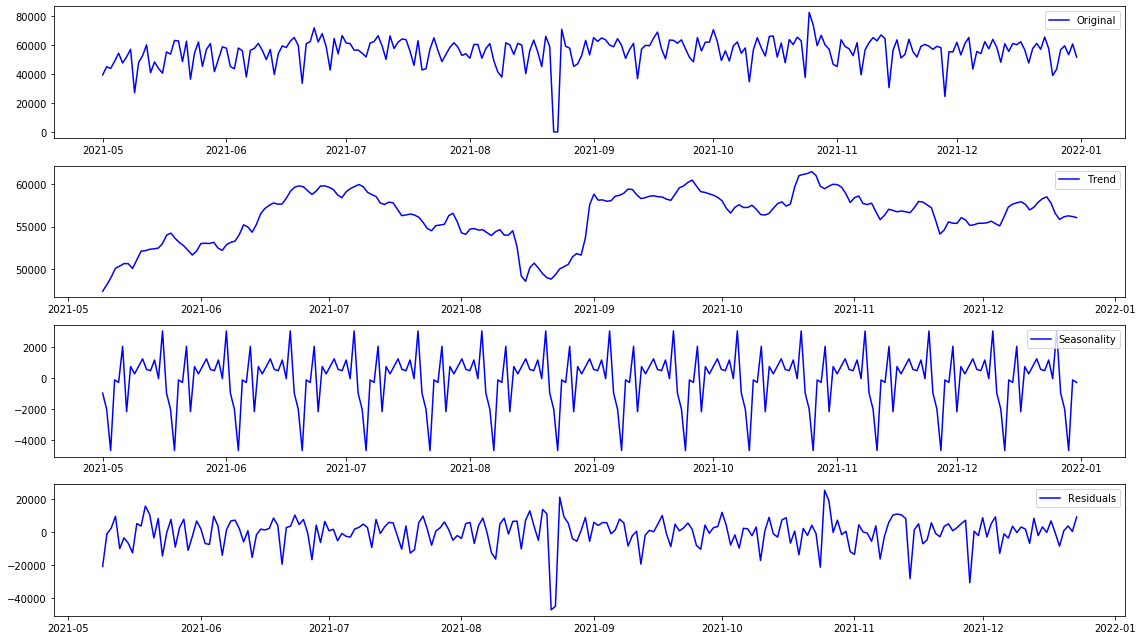

In [164]:
#finding if there is any seasonality in the time series created
decomposition = sm.tsa.seasonal_decompose(temp3, model='additive', period = 16)

#trend, seasonality and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#plot gathered statistics
plt.figure(figsize=(16,9))
plt.subplot(411)
plt.plot(temp3, label='Original', color='blue')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [165]:
#dickey fuller test to test for stationarity
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=12, center=False).mean()
    roll_std = TS.rolling(window=12, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [166]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

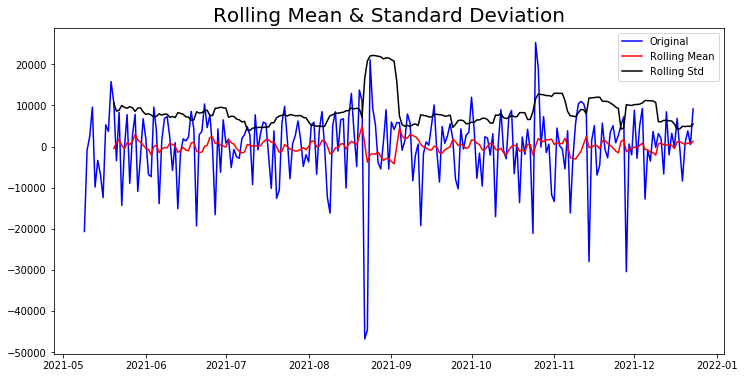

Results of Dickey-Fuller Test: 

Test Statistic                -6.032222e+00
p-value                        1.409094e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64


In [167]:
stationarity_check(ts_log_decompose)

Observations of the Data: The p-value is smaller than significance level (0.05). This is stationary.

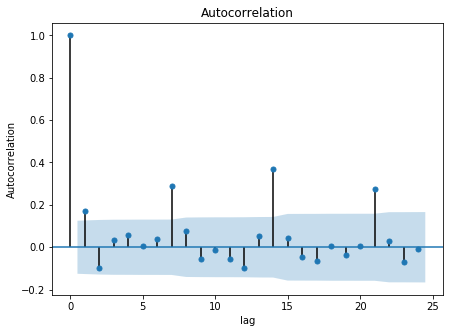

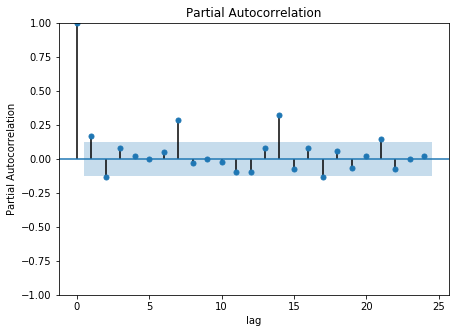

In [168]:
#checking for the ACF, lags and PCF of the data
rcParams['figure.figsize'] = 7,5
plot_acf(temp3) 
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

plot_pacf(temp3)
plt.xlabel('lag')
plt.ylabel('Partial Autocorrelation')
# plt.xlim(0, 24)
plt.ylim(-1, 1)
plt.show()

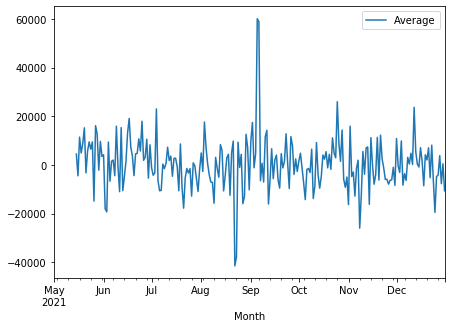

In [169]:
rcParams['figure.figsize'] = 7,5
temp3.diff(periods=14).plot();

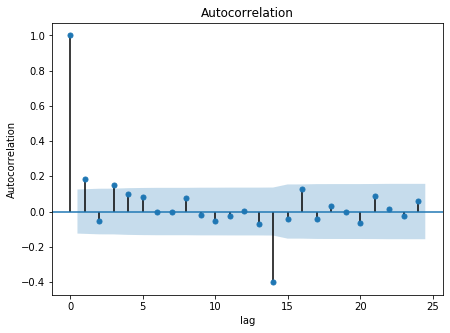

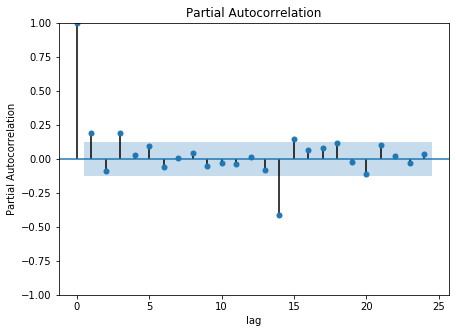

In [170]:
rcParams['figure.figsize'] = 7,5
plot_acf(temp3.diff(periods=14).bfill())
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
# plt.xlim(0, 24)
plt.show()

plot_pacf(temp3.diff(periods=14).bfill())
plt.xlabel('lag')
plt.ylabel('Partial Autocorrelation')
# plt.xlim(0, 24)
plt.ylim(-1,1)
plt.show()

In [171]:
#initial SARIMA
import numpy
lst = temp.Submodel.unique()
new = []
for s in lst:
    test = temp.Submodel.value_counts()
    try:
        if test[str(s)] > 200:
            new += [s]
    except Exception:
        pass

In [172]:
#Randomly select 3 submodels
random.seed(3)
submodel_dfs = []
submodel_list = random.sample(new, k=3)
print(submodel_list)

['1.5A G', '1.6A GLS S', '1.6A GLS']


In [173]:
for x in submodel_list:
    submodel_dfs.append(pd.DataFrame(temp[temp['Submodel'] == x][['Average']].copy()))
    
submodel_dfs

[            Average
 Month              
 2021-05-01  54344.0
 2021-05-02  54344.0
 2021-05-03  54344.0
 2021-05-04  54344.0
 2021-05-05  55150.0
 ...             ...
 2021-12-27  51888.0
 2021-12-28  72197.0
 2021-12-29  51800.0
 2021-12-30  43944.0
 2021-12-31  43944.0
 
 [245 rows x 1 columns],
             Average
 Month              
 2021-05-01  67050.0
 2021-05-02  76800.0
 2021-05-03  76800.0
 2021-05-04  76800.0
 2021-05-05  65894.0
 ...             ...
 2021-12-27  66300.0
 2021-12-28  69400.0
 2021-12-29  71800.0
 2021-12-30  58800.0
 2021-12-31  75019.0
 
 [245 rows x 1 columns],
                  Average
 Month                   
 2021-05-01  58162.666667
 2021-05-02  80800.000000
 2021-05-03  63344.000000
 2021-05-04  63800.000000
 2021-05-05  63800.000000
 ...                  ...
 2021-12-27  45800.000000
 2021-12-28  64800.000000
 2021-12-29  64800.000000
 2021-12-30  67050.000000
 2021-12-31  67050.000000
 
 [245 rows x 1 columns]]

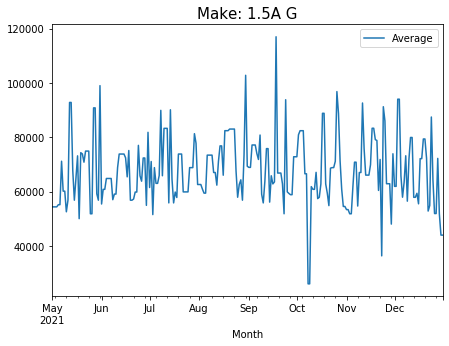

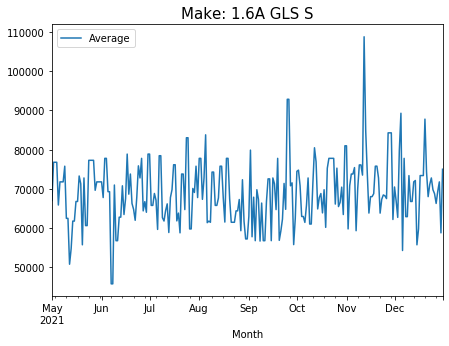

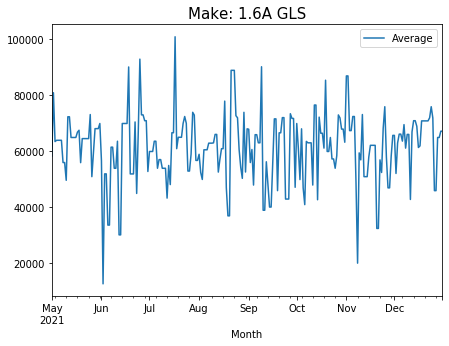

In [174]:
for df, name in zip(submodel_dfs, submodel_list):
    df.plot()
    plt.title(f"Make: {name}", fontsize=15)
    plt.show()

In [175]:
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

In [176]:
#Run SARIMA Model 
start = time.time()
ans = []

for df, name in zip(submodel_dfs, submodel_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, 
                                                                                                     para2, 
                                                                                                     output.aic))
            except:
                continue

Result for 1.5A G ARIMA (0, 0, 0) x (0, 0, 0, 4)12 : AIC Calculated = 6131.050960737086
Result for 1.5A G ARIMA (0, 0, 0) x (0, 0, 1, 4)12 : AIC Calculated = 5890.358526681052
Result for 1.5A G ARIMA (0, 0, 0) x (0, 1, 0, 4)12 : AIC Calculated = 5372.710113363866
Result for 1.5A G ARIMA (0, 0, 0) x (0, 1, 1, 4)12 : AIC Calculated = 5193.71657283862
Result for 1.5A G ARIMA (0, 0, 0) x (1, 0, 0, 4)12 : AIC Calculated = 5392.1487425890355
Result for 1.5A G ARIMA (0, 0, 0) x (1, 0, 1, 4)12 : AIC Calculated = 5302.748304776133
Result for 1.5A G ARIMA (0, 0, 0) x (1, 1, 0, 4)12 : AIC Calculated = 5237.886736528662
Result for 1.5A G ARIMA (0, 0, 0) x (1, 1, 1, 4)12 : AIC Calculated = 5192.710047785478
Result for 1.5A G ARIMA (0, 0, 1) x (0, 0, 0, 4)12 : AIC Calculated = 5950.340762636066
Result for 1.5A G ARIMA (0, 0, 1) x (0, 0, 1, 4)12 : AIC Calculated = 5809.674080448423
Result for 1.5A G ARIMA (0, 0, 1) x (0, 1, 0, 4)12 : AIC Calculated = 5320.245763904061
Result for 1.5A G ARIMA (0, 0, 1

In [177]:
print('Took', time.time()-start, 'seconds.')

Took 17.115966320037842 seconds.


In [178]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])
result

,name,pdq,pdqs,AIC
0,1.5A G,"(0, 0, 0)","(0, 0, 0, 4)",6131.050961
1,1.5A G,"(0, 0, 0)","(0, 0, 1, 4)",5890.358527
2,1.5A G,"(0, 0, 0)","(0, 1, 0, 4)",5372.710113
3,1.5A G,"(0, 0, 0)","(0, 1, 1, 4)",5193.716573
4,1.5A G,"(0, 0, 0)","(1, 0, 0, 4)",5392.148743
...,...,...,...,...
187,1.6A GLS,"(1, 1, 1)","(0, 1, 1, 4)",5180.604347
188,1.6A GLS,"(1, 1, 1)","(1, 0, 0, 4)",5174.461957
189,1.6A GLS,"(1, 1, 1)","(1, 0, 1, 4)",5150.208937
190,1.6A GLS,"(1, 1, 1)","(1, 1, 0, 4)",5218.363672


In [179]:
#Return the best set of parameters based on AIC
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]
best_para

,name,pdq,pdqs,AIC
43,1.5A G,"(1, 0, 1)","(0, 1, 1, 4)",5157.660794
189,1.6A GLS,"(1, 1, 1)","(1, 0, 1, 4)",5150.208937
125,1.6A GLS S,"(1, 1, 1)","(1, 0, 1, 4)",4960.511664


In [180]:
# plug the optimal parameter values into a new SARIMAX model.
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], submodel_dfs):
    
    df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary())

SARIMA Model Result for 1.5A G
                                     SARIMAX Results                                     
Dep. Variable:                           Average   No. Observations:                  245
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 4)   Log Likelihood               -2574.830
Date:                           Sun, 20 Mar 2022   AIC                           5157.661
Time:                                   08:51:34   BIC                           5171.499
Sample:                               05-01-2021   HQIC                          5163.240
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4859      0.241      2.020      0.043       0.015       0.957
ma.L1       

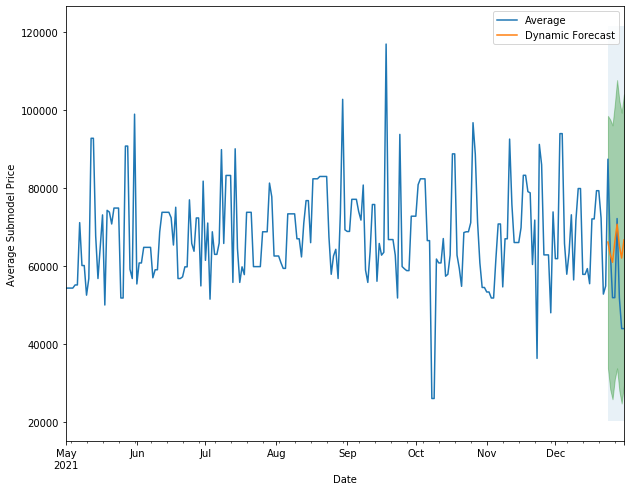

The Mean Squared Error of our forecasts is 14878.62


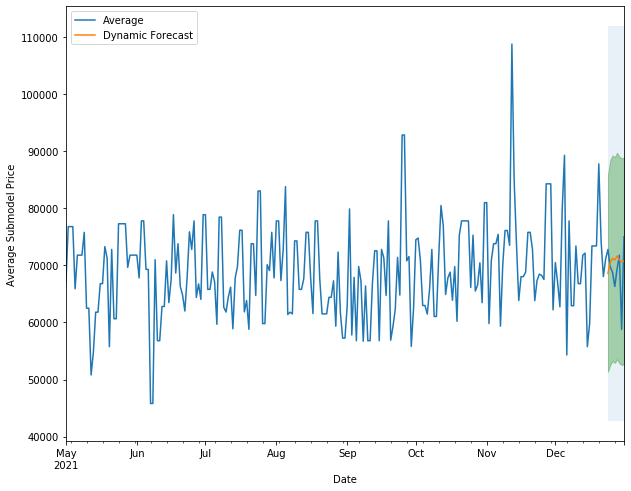

The Mean Squared Error of our forecasts is 5123.75


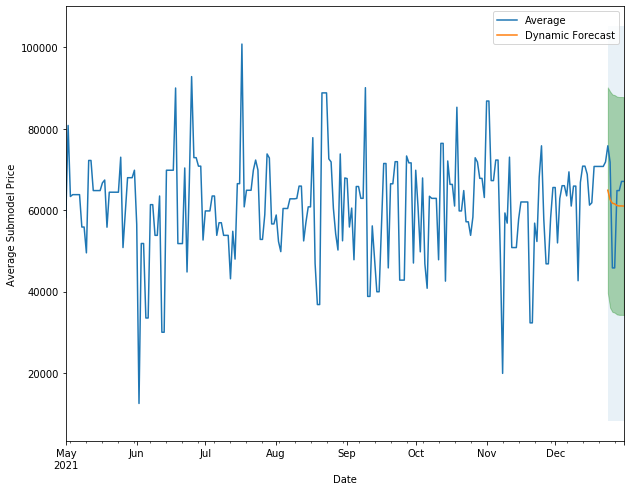

The Mean Squared Error of our forecasts is 10030.09


In [181]:
#Make Prediction post 2021 and compare with real values
summary_table = pd.DataFrame()
submodel = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], submodel_dfs):

    df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-01-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2021-12-24'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    submodel_forecasted = pred_dynamic.predicted_mean
    submodel_truth = df['2021-12-24':]['Average']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2021-05-01':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-12-24'), submodel_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average Submodel Price')

    plt.legend()
    plt.show()

    #print(type(zip_forecasted))
    #print(zip_truth)
    sqrt_mse = np.sqrt(((submodel_forecasted - submodel_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    submodel.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['submodel'] = submodel
summary_table['RMSE'] = MSE_Value

In [186]:
#Get the RMSE
summary_table.sort_values('RMSE').head()

,submodel,RMSE
1,1.6A GLS,5123.745458
2,1.6A GLS S,10030.090681
0,1.5A G,14878.623063


In [187]:
#Final Model 
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
conf_3Yr_L=[]
conf_3Yr_U=[]
conf_5Yr_L=[]
conf_5Yr_U=[]
for submodel, output, df in zip(submodel, models, submodel_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2021-12']['Average'][0])
    
    forecast_3Yr.append(forecast_3)
    conf_3Yr_L.append(pred_conf_3.iloc[:, 0][-1])
    conf_3Yr_U.append(pred_conf_3.iloc[:, 1][-1])
    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append(pred_conf_5.iloc[:, 0][-1])
    conf_5Yr_U.append(pred_conf_5.iloc[:, 1][-1])

forecast_table['Submodel'] = submodel
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3 Years Lower'] = conf_3Yr_L
forecast_table['3 Years Upper'] = conf_3Yr_U
forecast_table['5 Years Lower'] = conf_5Yr_L
forecast_table['5 Years Upper'] = conf_5Yr_U

forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Lower']=(forecast_table['3 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Upper']=(forecast_table['3 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Lower']=(forecast_table['5 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Upper']=(forecast_table['5 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']

forecast_table.head()

,Submodel,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
0,NaN,61900.0,56586.710269,56586.710269,8969.517407,104203.903131,1678.873748,111494.546791,-0.085837,-0.085837,-0.855097,0.683423,-0.972878,0.801204
1,NaN,70496.0,70580.634784,70580.802542,52248.818323,88912.451244,52099.996111,89061.608973,0.001201,0.001203,-0.258840,0.261241,-0.260951,0.263357
2,NaN,65555.0,61137.845383,61137.728628,34384.373985,87891.316780,34384.206605,87891.250650,-0.067381,-0.067383,-0.475488,0.340726,-0.475491,0.340725


In [184]:
forecast_table.sort_values('3Yr-ROI', ascending = False)[:]

,Submodel,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
1,NaN,70496.0,70580.634784,70580.802542,52248.818323,88912.451244,52099.996111,89061.608973,0.001201,0.001203,-0.258840,0.261241,-0.260951,0.263357
2,NaN,65555.0,61137.845383,61137.728628,34384.373985,87891.316780,34384.206605,87891.250650,-0.067381,-0.067383,-0.475488,0.340726,-0.475491,0.340725
0,NaN,61900.0,56586.710269,56586.710269,8969.517407,104203.903131,1678.873748,111494.546791,-0.085837,-0.085837,-0.855097,0.683423,-0.972878,0.801204


In [185]:
forecast_table.sort_values('5Yr-ROI', ascending = False)[:]

,Submodel,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
1,NaN,70496.0,70580.634784,70580.802542,52248.818323,88912.451244,52099.996111,89061.608973,0.001201,0.001203,-0.258840,0.261241,-0.260951,0.263357
2,NaN,65555.0,61137.845383,61137.728628,34384.373985,87891.316780,34384.206605,87891.250650,-0.067381,-0.067383,-0.475488,0.340726,-0.475491,0.340725
0,NaN,61900.0,56586.710269,56586.710269,8969.517407,104203.903131,1678.873748,111494.546791,-0.085837,-0.085837,-0.855097,0.683423,-0.972878,0.801204


The 1.6A GLS will experience the highest ROI in both a 3-year and 5-year interval, with a 3-Year ROI of xxx and 5-Year ROI of yyy. 